# A basic neural network library supported auto differentiation

## Outline

- Motivation
- Introduction
- Implementation
- Application

## Motivation

Most deep learning courses aim to teach math behind the network, architecture and their applications, but seldom course talk about how to implement and design the deep learning library.

### Goal

- Implement this kind of library
- Learn how and why the priors (Tensorflow and PyTorch etc.) design their work.

## Introduction

### Computational Graph

### Auto Differentiation

### VJP

### Back propagation

## Implementation

### Forward Propagation

Q: How do we obtain the computational graph?

A: Trace every operation with the wrapped version by decorator.

That's say we want to print the numpy function name during the calculation.

We can fully leverage the power of decorator.

In [1]:
%matplotlib inline 

import numpy as np


def get_name_decorator(func):
    def wrapped(*args, **kwargs):
        print(f"Wrapped version of numpy function, and its name is {func.__name__}")
        result = func(*args, **kwargs)
        return result
    return wrapped
        

for function in [np.add, np.subtract, np.ndarray.__getitem__, np.ndarray.__add__]:
    globals()[function.__name__] = get_name_decorator(function)

print(add(1, 2))
print(subtract(1, 2))
print(__getitem__(np.array([0,1,2]), [2]))
print(__add__(np.array([0,1]), np.array([1,0])))

Wrapped version of numpy function, and its name is add
3
Wrapped version of numpy function, and its name is subtract
-1
Wrapped version of numpy function, and its name is __getitem__
[2]
Wrapped version of numpy function, and its name is __add__
[1 1]


No things have been little complicated. Due to the same reason, we can put the operator on the computational graph on the fly.

In [2]:
class Node:
    def __init__(self):
        self.gradient = 0

class OperationNode(Node):
    def __init__(self, func, args, kwargs, result):
        super().__init__()
        self.recipe = (func, args, kwargs, result, len(args))


class VariableNode(Node):
    def __init__(self, var):
        super().__init__()
        self.var = var


class PlaceholderNode(Node):
    def __init__(self, var):
        super().__init__()
        self.var = var


class ConstantNode(Node):
    def __init__(self, constant):
        super().__init__()
        self.constant = constant

def plot_graph(backward=False, backward_result={}):
    arrow_style = "<|-" if backward else "-|>" 
    edge_labels = {}
    if backward:
        info = "output"
        node_index = add_node(node=ConstantNode(info), info=info)
        default_graph.add_edge(node_index - 1, node_index)
        for node, result in backward_result.items():
            for edge in default_graph.edges:
                head, tail = edge
                if head == node:
                    edge_labels[tuple(edge)] = str(result)
        edge_labels[(node_index, node_index-1)] = "1"
    plt.figure(3,figsize=(10,10)) 
    limits=plt.axis('off')
    labels = {i: default_graph.nodes[i]['info'] for i in default_graph.nodes}
    pos = nx.spring_layout(default_graph)
    nx.draw_networkx_nodes(default_graph, pos, node_size = 3000, alpha=0.8)
    nx.draw_networkx_labels(default_graph, pos, labels=labels, font_color="w")
    nx.draw_networkx_edges(default_graph, pos, width=3, arrowstyle=arrow_style, arrowsize=15)
    if backward:
        nx.draw_networkx_edge_labels(default_graph,pos,edge_labels=edge_labels,font_size=30)
    plt.show()     

Forward pass
Result is 2
Corresponding computational graph is 


/home/chenyee/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/chenyee/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


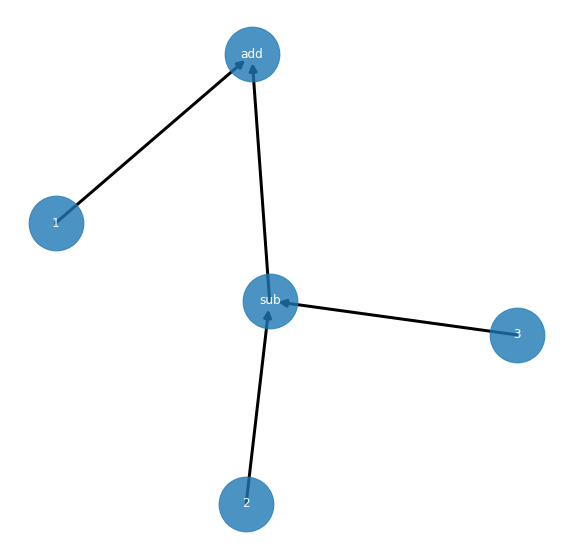

In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

default_graph = nx.DiGraph()
stack = []

def add_node(node, info):
    node_index = len(default_graph.nodes) + 1
    default_graph.add_node(node_index, node=node, info=info)
    return node_index


def constant(array):
    def wrapped(*args, **kwargs):
        node = ConstantNode("".join(str(a) for a in args))
        node_index = add_node(node, *args)
        stack.append(node_index)
        value = array(*args, **kwargs)
        return value
    return wrapped

        
def primitive(func):
    def wrapped(*args, **kwargs):
        result = func(*args, **kwargs)
        node = OperationNode(func, args, kwargs, result)
        node_index = add_node(node, func.__name__[:3])
        parents = stack[-len(args):]
        
        for parent in parents:
            default_graph.add_edge(parent, node_index)
            stack.pop()
        
        stack.append(node_index)
        return result
    return wrapped
        

def wrapped_numpy_operator():
    for function in [np.add, np.subtract]:
        globals()[function.__name__] = primitive(function)

    globals()["const"] = constant(np.array)


wrapped_numpy_operator()
result = add(const(1), subtract(const(3), const(2)))
print("Forward pass")
print(f"Result is {result}")
print("Corresponding computational graph is ")
plot_graph()

### Register VJP after loading

- We need to look up the corresponding VJP of given operation while backtracking.
- Load in `__init__.py`

In [4]:
from collections import defaultdict

import numpy as np

primitive_vhp = defaultdict(dict)

def register_vjp(func, vhp_list):
    for i, downstream in enumerate(vhp_list):
        primitive_vhp[func.__name__][i] = downstream

register_vjp(
    np.add,
    [
        lambda upstream, result, x, y: upstream,  # w.r.t. x
        lambda upstream, result, x, y: upstream,  # w.r.t. y
    ])

register_vjp(
    np.subtract,
    [
        lambda upstream, result, x, y: upstream,  # w.r.t. x
        lambda upstream, result, x, y: -upstream,  # w.r.t. y
    ])

register_vjp(
    np.negative,
    [
        lambda upstream, result, x: -upstream,  # w.r.t. x
    ])

func = np.negative
x = -6
upstream = 100
result = func(x)
vjp = primitive_vhp[func.__name__][0]

print(f"Upstream is {upstream}")
print(f"Operator is {func.__name__}, x is {x}, result is {result}")
print(f"Downstream is {vjp(upstream, result, x)}")

Upstream is 100
Operator is negative, x is -6, result is 6
Downstream is -100


### Backward Propagation

Backward pass


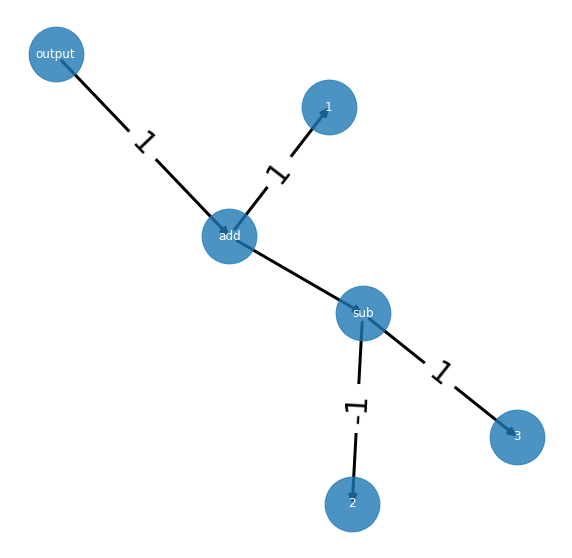

In [5]:
import networkx as nx

def backward_prop(upstream):
    default_graph.nodes[len(default_graph.nodes())]['node'].gradient = upstream

    gradient_dict = {}
    for node in reversed(list(nx.topological_sort(default_graph))):
        child_node = default_graph.nodes[node]['node']
        if isinstance(child_node, OperationNode):
            func, args, kwargs, result, arg_num = child_node.recipe
            upstream = child_node.gradient

            for i, parent in zip(range(arg_num), default_graph.predecessors(node)):
                vhp = primitive_vhp[func.__name__][i]
                downstream = vhp(upstream, result, *args, **kwargs)
                default_graph.nodes[parent]['node'].gradient += downstream
        else:
            gradient_dict[node] = child_node.gradient

    return gradient_dict

print("Backward pass")
backward_result = backward_prop(np.ones_like(result))
plot_graph(True, backward_result)

### Simple demo

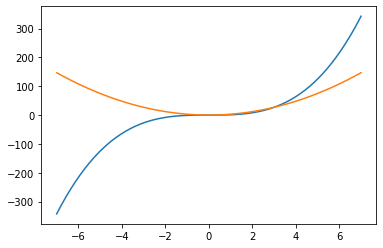

<Figure size 432x288 with 0 Axes>

In [6]:
%run examples/simple/poly_test.py

### Boston dataset – linear regression with multiple variables

#### Mean Square Error

100%|██████████| 200/200 [00:00<00:00, 1925.71it/s]


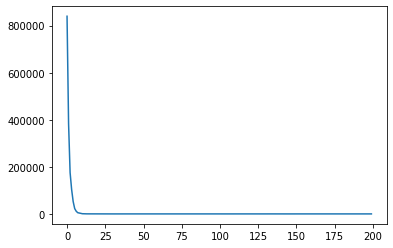

In [7]:
%run examples/regression/boston.py

### Iris dataset – classification 

#### Cross Entropy

100%|██████████| 300/300 [00:00<00:00, 1591.33it/s]


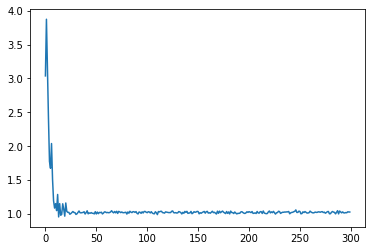

In [8]:
%run examples/classification/iris.py

### Hand-written digits dataset – classification

100%|██████████| 300/300 [00:00<00:00, 1359.73it/s]


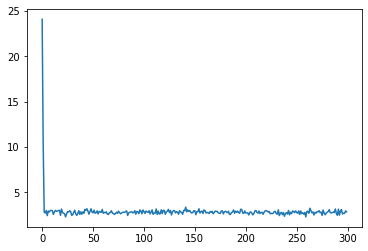

In [9]:
%run examples/classification/digits.py

### Open Source contributions

Find the redundant calculations of the derivatives of power function.
1. [PyTorch](https://github.com/pytorch/pytorch/pull/28651)
2. [JAX](https://github.com/google/jax/pull/157)
3. [Autograd](https://github.com/HIPS/autograd/pull/541)

### Reference